---
---

# IMPORTS

In [2]:
INTERACTIVE = False
FIGWIDTH    = 12


# CHOOSE INTERACTIVE ON/OFF
if INTERACTIVE:
    %matplotlib widget
else:
    %matplotlib inline
#----------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import pandas as pd
from scipy.interpolate import interp1d
import glob
import sys
sys.path.append('../')

import pynumdiff
import fillingpatterns as fp

# Make sure this import is after pandas
import Backend.ABPPandas

import Backend.Constants as cst
import Backend.NXCALS as nx


# Matplotlib config
#for key in plt.rcParams.keys():
#    if 'date.auto' in key:
#        plt.rcParams[key] = "%H:%M"


# Creating NXCALS variable containers
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]

buckets   = np.arange(3564)


# Locating data
DATA_PATH = '/eos/project/l/lhc-lumimod/LuminosityFollowUp/2022_test_v0.2.2/'
SAVEPATH  = '../Results_Lumi_V2/wires_on'

def importData(_fill,columns):
    # Importing fill data
    df = pd.read_parquet(DATA_PATH+f'HX:FILLN={FILL}',columns=columns)
    df = df.sort_index()
    df.index.name = 'unix'
    df.insert(0,'Timestamp',df.index)
    df.insert(1,'Time',1e-9*(df.index - df.index[0]))
    df['Timestamp'] = df['Timestamp'].apply(lambda t: pd.Timestamp(t).tz_localize('UTC'))
    return df

def wireROI(df):
    stable_ts  = df[df['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
    wire_start = df[(df[wires['B2'][0]['I']]>10)&(df['Timestamp']>stable_ts)]['Timestamp'].min()
    wire_stop  = df[(df[wires['B2'][0]['I']]>295)&(df['Timestamp']>wire_start)]['Timestamp'].min()
    wire_start,wire_stop = wire_start-pd.Timedelta(minutes=3),wire_stop+pd.Timedelta(minutes=3)
    return wire_start,wire_stop


def getFillingPatt(df):

    filled_buckets = {}
    patterns       = {}
    bunch_I        = {}
    for beam in beams:
        
        filled_ts = np.min(df[df[beam['Intensity']]== np.max(df[beam['Intensity']])].index)

        sub = df.dropna(subset=[beam['bb_Intensity']])
        _ts = sub.index[sub.index.get_loc(filled_ts, method='nearest')]
        
        
        bunch_I[beam.name]        =df.loc[_ts,beam['bb_Intensity']]
        filled_buckets[beam.name] = np.arange(len(buckets))[bunch_I[beam.name]!=0]
        patterns[beam.name]       = (bunch_I[beam.name]!=0)


    # Figuring out filling patterns
    patt = fp.FillingPattern(patterns['B1'], patterns['B2'])
    patt.compute_beam_beam_schedule(n_lr_per_side=21)

    for bb_patt in [patt.b1,patt.b2]:
        train_num     = np.repeat(np.arange(len(bb_patt.train_lengths)),bb_patt.train_lengths)
        train_lengths = np.repeat(bb_patt.train_lengths,bb_patt.train_lengths)
        bb_patt.bb_schedule.insert(0,'Train',train_num)
        bb_patt.bb_schedule.insert(1,'Train Lengths',train_lengths)
        bb_patt.bb_schedule.insert(2,'Tag',None)


        targetTrain = bb_patt.bb_schedule['Train Lengths'].max()

        grouped = bb_patt.bb_schedule.groupby('Train')
        for train in list(grouped.groups.keys()):
            if grouped.get_group(train)['Train Lengths'].max() == targetTrain:
                _first  = grouped.get_group(train).index[0]
                _middle = grouped.get_group(train).index[targetTrain//2]

                bb_patt.bb_schedule.loc[_first,'Tag']  = 'first'
                bb_patt.bb_schedule.loc[_middle,'Tag'] = 'middle'

    return patt


2022-09-21 21:21:02,937 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



# Macro observable, Fill/Fill

In [3]:

fills_info = pd.read_pickle("wires_on.pkl")
fills_on   = list(fills_info.index)

fills_info = pd.read_pickle("wires_off.pkl")
fills_off   = list(fills_info.index)


df_list = []
for FILL in fills_on:
    print(FILL)
    # Importing some data for timescales
    #-----------------------------------
    beam = beams[1]
    var_needed  = ['HX:BMODE','HX:BETASTAR_IP1']
    var_needed += [wires['B2'][0]['I']]
    var_needed += [beam['Intensity'],beam['Luminosity']['ATLAS'],beam['Nb']]


    #var_needed += [beam['bb_Emittance_H'] for beam in beams] + [beam['bb_Emittance_V'] for beam in beams]

    df = importData(FILL,columns=var_needed)
    df.insert(0,'Fill',FILL)

    df_list.append(df)

    #-----------------------------------

database = pd.concat(df_list,axis=0)   

# Just to copy
if False:
    wire_start,wire_stop = wireROI(database)
    start_ts             = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
    stop_ts              = database[database[beams[0]['Luminosity']['ATLAS']]>1000]['Timestamp'].max()
    beta_ts              = database[(database['HX:BETASTAR_IP1']<32)&(database['Timestamp']>start_ts )]['Timestamp'].min()

8033
8063
8072
8076
8081
8083
8088
8094
8102
8103
8112
8113
8115
8118
8120
8124
8128
8132
8136
8142
8143
8146


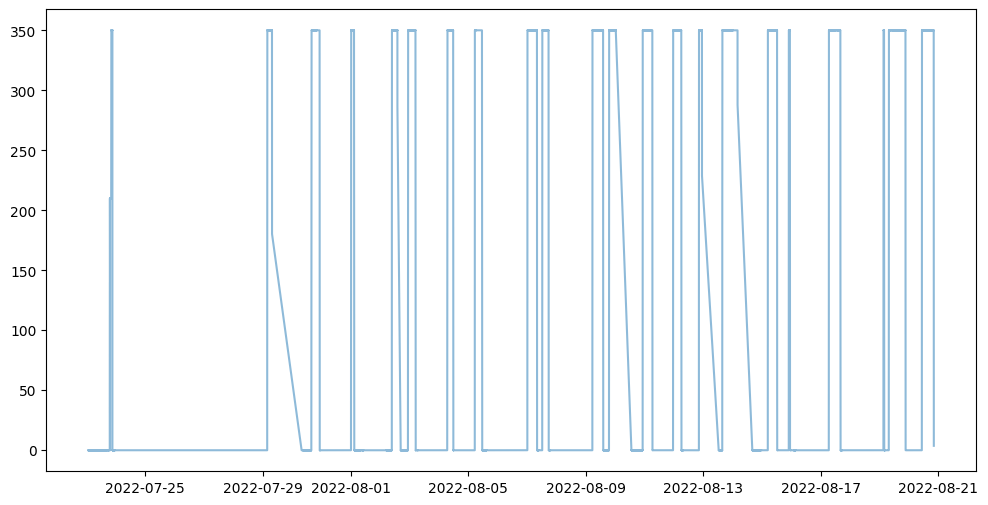

In [3]:


for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%Y-%m-%d" # '%Y-%m-%d %H:%M:%S'

plt.figure(figsize=(12,6))
database.nxPlot('Timestamp',wires['B2'][0]['I'],color='C0',alpha=0.5)


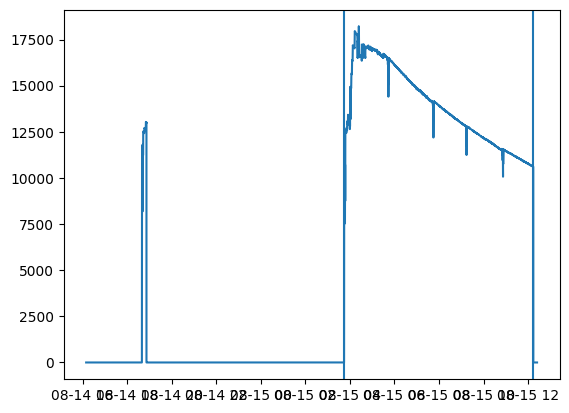

In [12]:
df = grouped.get_group(8128)
wire_start,wire_stop = wireROI(df)
wire_start = wire_stop
wire_stop  = df[(df[wires['B2'][0]['I']]<290)&(df['Timestamp']>wire_start)]['Timestamp'].min()

start_ts   = df[df['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
stop_ts    = df[df[beams[0]['Luminosity']['ATLAS']]>1000]['Timestamp'].max()
FILL = 8128
if FILL == 8128:
    start_ts   = df[(df[beams[0]['Luminosity']['ATLAS']]>2500)&(df['Timestamp']>(stop_ts-pd.Timedelta(hours=10)))]['Timestamp'].min()

beta_ts    = df[(df['HX:BETASTAR_IP1']<32)&(df['Timestamp']>start_ts )]['Timestamp'].min()

wire_stop  = np.min([wire_stop,stop_ts]) 


plt.figure()
df.nxPlot('Timestamp',beam['Luminosity']['ATLAS'])
plt.axvline(start_ts)
plt.axvline(stop_ts)

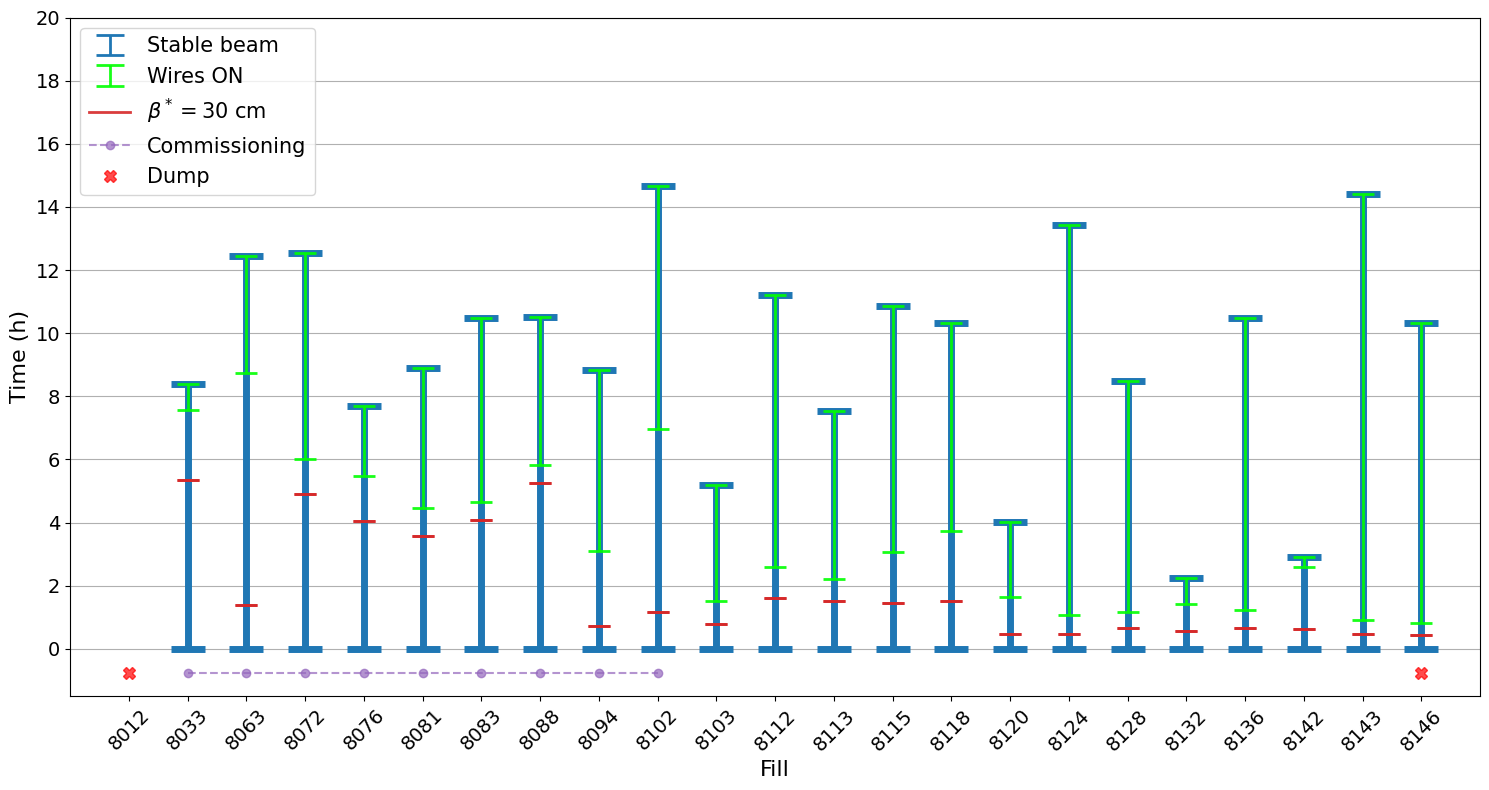

In [14]:
def plot_fill_time_info(x):
    fill_length = (stop_ts-start_ts).seconds/3600
    plt.errorbar(x, [0], yerr=[[0],[fill_length]],ecolor='C0', 
                                    elinewidth=5, 
                                    capsize=12,
                                    capthick = 5,alpha=1)

    wire_time = (wire_start-start_ts).seconds/3600
    wire_ramp = (wire_stop-wire_start).seconds/3600
    plt.errorbar(x, [wire_time], yerr=[[0],[wire_ramp]],ecolor='lime', 
                                    elinewidth=2, 
                                    capsize=8,
                                    capthick = 2,alpha=0.9)
    beta_time = (beta_ts - start_ts).seconds/3600                           
    plt.errorbar(x, [beta_time], yerr=[[0],[0]],ecolor='C3', 
                                    elinewidth=2, 
                                    capsize=8,
                                    capthick = 2,alpha=0.9)



plt.figure(figsize=(15,8))

grouped = database.groupby('Fill')
xloc = 1
for FILL, df in grouped:

    wire_start,wire_stop = wireROI(df)
    wire_start = wire_stop
    wire_stop  = df[(df[wires['B2'][0]['I']]<290)&(df['Timestamp']>wire_start)]['Timestamp'].min()
    
    start_ts   = df[df['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
    stop_ts    = df[df[beams[0]['Luminosity']['ATLAS']]>1000]['Timestamp'].max()
    if FILL == 8128:
        start_ts   = df[(df[beams[0]['Luminosity']['ATLAS']]>2500)&(df['Timestamp']>(stop_ts-pd.Timedelta(hours=10)))]['Timestamp'].min()
    
    beta_ts    = df[(df['HX:BETASTAR_IP1']<32)&(df['Timestamp']>start_ts )]['Timestamp'].min()
    wire_stop  = np.min([wire_stop,stop_ts]) 

    plot_fill_time_info(xloc)
    xloc += 1


# ADDING DUMPS
plt.plot(np.arange(1,fills_on.index(8102)+1+1),-0.75*np.ones(fills_on.index(8102)+1),'--o',color='C4',alpha=0.7,label='Commissioning')
plt.plot([0,fills_on.index(8146)+1],[-0.75,-0.75],'X',ms=8,color='red',alpha=0.7,label='Dump')

# LEGEND SHENANIGANS
#=======================================================
plt.errorbar(-10, [0], yerr=[[0],[0]],fmt ='none',ecolor='C0',elinewidth=2,capsize=10,capthick = 2,alpha=1,  label='Stable beam')
plt.plot([np.nan],[np.nan],color='C3',alpha=0.9,lw=2,label = r'$\beta^* = 30$ cm')
plt.errorbar(-10, [0], yerr=[[0],[0]],fmt ='none',ecolor='lime',elinewidth=2,capsize=10,capthick = 2,alpha=0.9,label='Wires ON')
plt.legend()
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,4,2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=15,loc='upper left')
#=======================================================

plt.xlim([-1,len(fills_on)+1])
plt.ylim([-1.5,20])
plt.xticks(range(len(fills_on)+1),labels=[8012]+fills_on,rotation=45,fontsize=14);
plt.yticks(np.arange(0,22,2),fontsize=14)
plt.grid(axis='y')
plt.ylabel('Time (h)',fontsize=16)
plt.xlabel('Fill',fontsize=16)

plt.tight_layout()
plt.savefig('../Results_Lumi_V2/Uppsala/fill_overview.png',dpi=300)

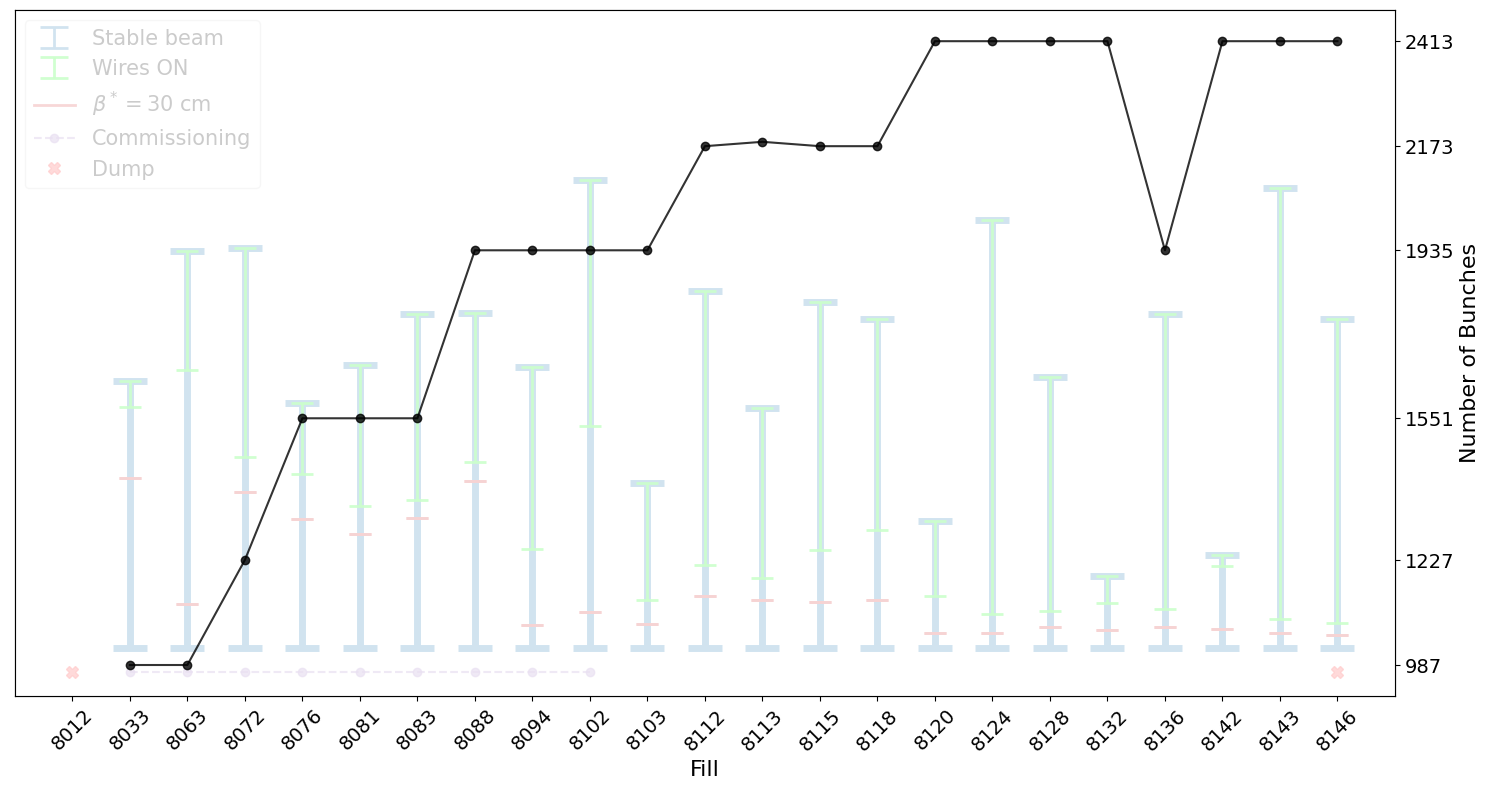

In [15]:
def plot_fill_time_info(x):
    fill_length = (stop_ts-start_ts).seconds/3600
    plt.errorbar(x, [0], yerr=[[0],[fill_length]],ecolor='C0', 
                                    elinewidth=5, 
                                    capsize=12,
                                    capthick = 5,alpha=1)

    wire_time = (wire_start-start_ts).seconds/3600
    wire_ramp = (wire_stop-wire_start).seconds/3600
    plt.errorbar(x, [wire_time], yerr=[[0],[wire_ramp]],ecolor='lime', 
                                    elinewidth=2, 
                                    capsize=8,
                                    capthick = 2,alpha=0.9)
    beta_time = (beta_ts - start_ts).seconds/3600                           
    plt.errorbar(x, [beta_time], yerr=[[0],[0]],ecolor='C3', 
                                    elinewidth=2, 
                                    capsize=8,
                                    capthick = 2,alpha=0.9)



plt.figure(figsize=(15,8))

grouped = database.groupby('Fill')
xloc = 1
for FILL, df in grouped:

    wire_start,wire_stop = wireROI(df)
    wire_start = wire_stop
    wire_stop  = df[(df[wires['B2'][0]['I']]<290)&(df['Timestamp']>wire_start)]['Timestamp'].min()
    
    start_ts   = df[df['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
    stop_ts    = df[df[beams[0]['Luminosity']['ATLAS']]>1000]['Timestamp'].max()
    if FILL == 8128:
        start_ts   = df[(df[beams[0]['Luminosity']['ATLAS']]>2500)&(df['Timestamp']>(stop_ts-pd.Timedelta(hours=10)))]['Timestamp'].min()
    
    beta_ts    = df[(df['HX:BETASTAR_IP1']<32)&(df['Timestamp']>start_ts )]['Timestamp'].min()

    wire_stop  = np.min([wire_stop,stop_ts]) 

    plot_fill_time_info(xloc)
    xloc += 1


# ADDING DUMPS
plt.plot(np.arange(1,fills_on.index(8102)+1+1),-0.75*np.ones(fills_on.index(8102)+1),'--o',color='C4',alpha=0.7,label='Commissioning')
plt.plot([0,fills_on.index(8146)+1],[-0.75,-0.75],'X',ms=8,color='red',alpha=0.7,label='Dump')

# LEGEND SHENANIGANS
#=======================================================
plt.errorbar(-10, [0], yerr=[[0],[0]],fmt ='none',ecolor='C0',elinewidth=2,capsize=10,capthick = 2,alpha=1,  label='Stable beam')
plt.plot([np.nan],[np.nan],color='C3',alpha=0.9,lw=2,label = r'$\beta^* = 30$ cm')
plt.errorbar(-10, [0], yerr=[[0],[0]],fmt ='none',ecolor='lime',elinewidth=2,capsize=10,capthick = 2,alpha=0.9,label='Wires ON')
plt.legend()
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,4,2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=15,loc='upper left')
#=======================================================

plt.xlim([-1,len(fills_on)+1])
plt.ylim([-1.5,20])
plt.xticks(range(len(fills_on)+1),labels=[8012]+fills_on,rotation=45,fontsize=14);
plt.yticks(np.arange(0,22,2),fontsize=14)
plt.grid(axis='y')
plt.ylabel('Time (h)',fontsize=16)
plt.xlabel('Fill',fontsize=16)


ax_og = plt.gca()
ax2   = ax_og.twinx()
ax2.set_zorder(100)
ax2.patch.set_facecolor('white')
ax2.patch.set_alpha(0.80)
ax2.patch.set_visible(True)

ax_og.get_yaxis().set_visible(False)

plt.sca(ax2)
xloc = 1
nbunches = []
x_vec    = []
y_vec    = []
for FILL, df in grouped:
    nbunches.append(df[df[beam['Nb']]<3000][beam['Nb']].max())
    x_vec.append(xloc)
    y_vec.append(nbunches[-1])
    xloc += 1
plt.plot(x_vec,y_vec,'-o',color='k',alpha=0.8)

nbunches = list(set(nbunches))
nbunches = list(np.sort(nbunches).astype(int))
nbunches.remove(2183)

plt.yticks(nbunches,fontsize=14)
plt.ylabel('Number of Bunches',fontsize=16)

plt.tight_layout()
plt.savefig('../Results_Lumi_V2/Uppsala/fill_overview_intensity.png',dpi=300)

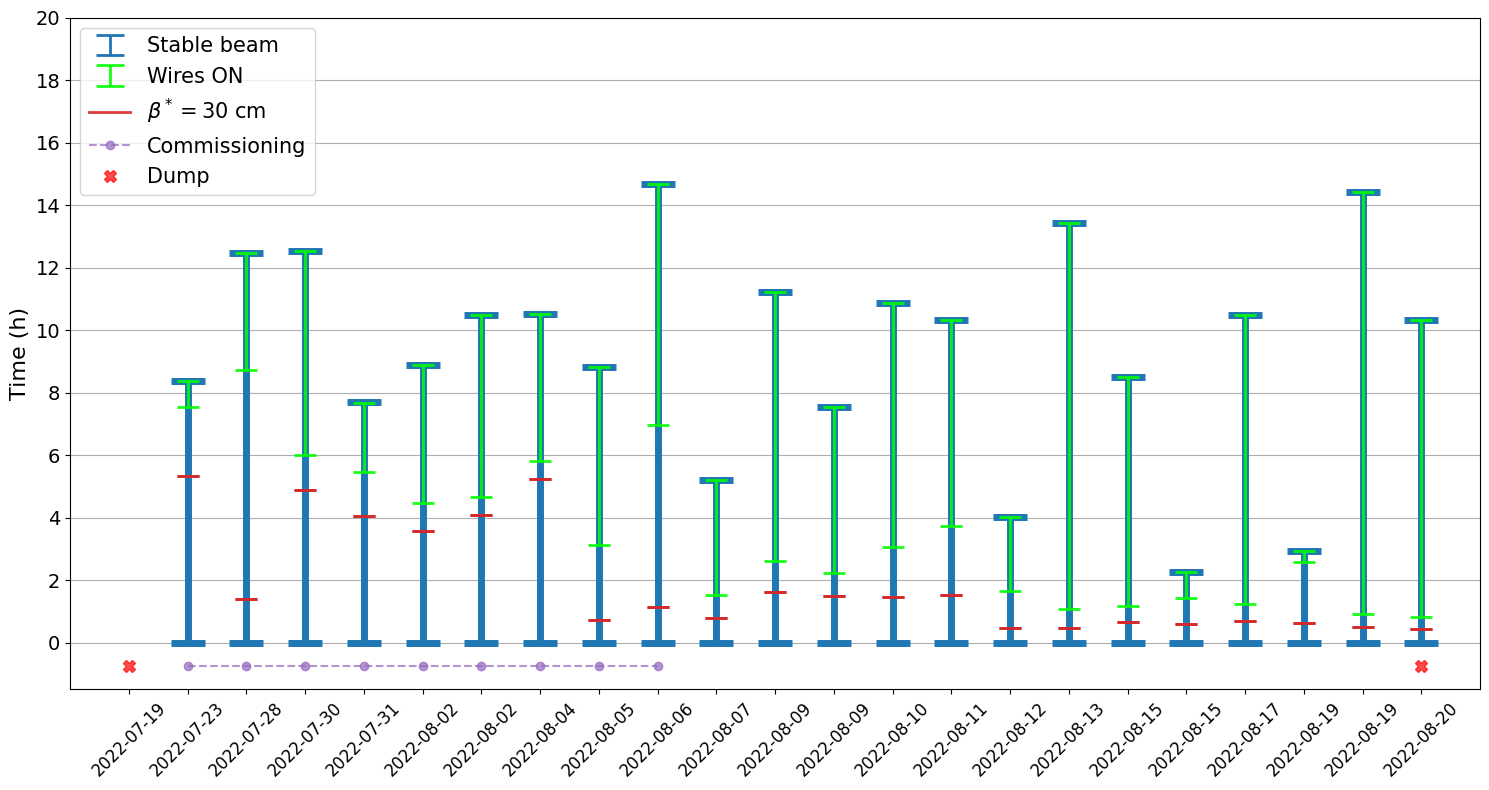

In [22]:
def plot_fill_time_info(x):
    fill_length = (stop_ts-start_ts).seconds/3600
    plt.errorbar(x, [0], yerr=[[0],[fill_length]],ecolor='C0', 
                                    elinewidth=5, 
                                    capsize=12,
                                    capthick = 5,alpha=1)

    wire_time = (wire_start-start_ts).seconds/3600
    wire_ramp = (wire_stop-wire_start).seconds/3600
    plt.errorbar(x, [wire_time], yerr=[[0],[wire_ramp]],ecolor='lime', 
                                    elinewidth=2, 
                                    capsize=8,
                                    capthick = 2,alpha=0.9)
    beta_time = (beta_ts - start_ts).seconds/3600                           
    plt.errorbar(x, [beta_time], yerr=[[0],[0]],ecolor='C3', 
                                    elinewidth=2, 
                                    capsize=8,
                                    capthick = 2,alpha=0.9)



plt.figure(figsize=(15,8))

grouped = database.groupby('Fill')
xloc = 1
ts_list = ['2022-07-19']
for FILL, df in grouped:

    wire_start,wire_stop = wireROI(df)
    wire_start = wire_stop
    wire_stop  = df[(df[wires['B2'][0]['I']]<290)&(df['Timestamp']>wire_start)]['Timestamp'].min()
    
    start_ts   = df[df['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
    stop_ts    = df[df[beams[0]['Luminosity']['ATLAS']]>1000]['Timestamp'].max()
    if FILL == 8128:
        start_ts   = df[(df[beams[0]['Luminosity']['ATLAS']]>2500)&(df['Timestamp']>(stop_ts-pd.Timedelta(hours=10)))]['Timestamp'].min()
    
    beta_ts    = df[(df['HX:BETASTAR_IP1']<32)&(df['Timestamp']>start_ts )]['Timestamp'].min()
    wire_stop  = np.min([wire_stop,stop_ts]) 

    plot_fill_time_info(xloc)
    xloc += 1
    ts_list.append(str(start_ts)[:10])


# ADDING DUMPS
plt.plot(np.arange(1,fills_on.index(8102)+1+1),-0.75*np.ones(fills_on.index(8102)+1),'--o',color='C4',alpha=0.7,label='Commissioning')
plt.plot([0,fills_on.index(8146)+1],[-0.75,-0.75],'X',ms=8,color='red',alpha=0.7,label='Dump')

# LEGEND SHENANIGANS
#=======================================================
plt.errorbar(-10, [0], yerr=[[0],[0]],fmt ='none',ecolor='C0',elinewidth=2,capsize=10,capthick = 2,alpha=1,  label='Stable beam')
plt.plot([np.nan],[np.nan],color='C3',alpha=0.9,lw=2,label = r'$\beta^* = 30$ cm')
plt.errorbar(-10, [0], yerr=[[0],[0]],fmt ='none',ecolor='lime',elinewidth=2,capsize=10,capthick = 2,alpha=0.9,label='Wires ON')
plt.legend()
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,4,2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=15,loc='upper left')
#=======================================================

plt.xlim([-1,len(fills_on)+1])
plt.ylim([-1.5,20])
plt.xticks(range(len(fills_on)+1),labels=ts_list,rotation=45,fontsize=12);
plt.yticks(np.arange(0,22,2),fontsize=14)
plt.grid(axis='y')
plt.ylabel('Time (h)',fontsize=16)
#plt.xlabel('Fill',fontsize=16)

plt.tight_layout()
plt.savefig('../Results_Lumi_V2/Uppsala/fill_overview_timestamp.png',dpi=300)

'2022-07-23'

In [83]:
nbunches = []
for FILL, df in grouped:
    nbunches.append(df[df[beam['Nb']]<3000][beam['Nb']].max())
    plt.plot(xloc,nbunches[-1],'-o',color='k',alpha=0.8)
    xloc += 1
nbunches = list(set(nbunches))
nbunches = list(np.sort(nbunches).astype(int))

[987, 1227, 1551, 1935, 2173, 2183, 2413]